## Tutorial 2: Quantum Kernel
#### Julien Rauch, December 2025

Documentation from KIT: https://publikationen.bibliothek.kit.edu/1000148603

### 1 - Introduction
In quantum machine learning, the first step is often to figure out how to include our data in the quantum circuit. To do this, we use variational circuits (also known as quantum maps). The transformation of classical data into quantum states is called quantum embbeding.

- For a feature map (quantum circuit for data embedding) $\phi$ : $𝑋 \rightarrow 𝐻^n$ , and an inner product defined on $𝐻^n$.
- We defines a kernel function as: $k(x_i, x_j) = |\braket{\phi(x_i)|\phi(x_j)}_{H^n}|^2$. We can see it like a measure of similarity between $x_i$ and $x_j$ in the Hilbert space.

Finally, the kernel method makes it possible to calculate distances or similarities in a projection space (often in higher dimensions) without having to recalculate their new position. It's call Kernel trick.

### 2 - Quantum Embedding

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
import numpy as np
from IPython.display import display, Markdown
from sklearn.preprocessing import MinMaxScaler

To get started, we propose to use an extremely simple circuit for embedding: a simple phase encoding with one feature per qubit but "vertical repetition". 
Here is an example of this circuit for 3 qubits and data vector of 2 features:

![image](./img/circuit_embedding.png)

Implement the function that returns the circuit of ```nb_qubits``` for a data vector embedding of ```nb_feature``` :

In [3]:
def embbeding_circuit(nb_qubit, nb_feature, name="input"):
    """
        nb_qubit : number of qubits in the circuit
        nb_feature : number of features of a data vector
        name : name will be the identifier of the ParameterVector
        This function return the circuit of embedding
    """
    x = ParameterVector(name, nb_feature)
    
    # TODO
    circ = QuantumCircuit(nb_qubit)
    circ.h(range(nb_qubit))
    for i in range(nb_qubit):
        circ.rz(x[i % nb_feature], i)
    return circ
    

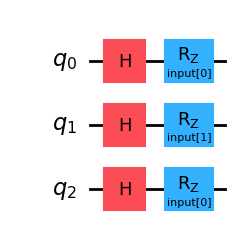

In [4]:
# Print the circuit
embbeding_circuit(3,2).draw('mpl') # Basic printing, you can improve

Now that we have a circuit that transforms our classical data into a quantum state, we can calculate the ```fidelity```, which is a measure of similarity in the space of quantum states.

### 3 - Fidelity Circuit

We have two methods for calculating the fidelity between two quantum states: the adjoint method and the swap test.

#### 3.1 - Calculation using the Adjoint Method 

Consider the following circuit:

![image](./img/adjoint.png)

Previousely for kernel function $k$ we defined: $k(x_i, x_j) = |\braket{\phi(x_i)|\phi(x_j)}_{H^n}|^2$

So, for the feature map $U$, we have $k(x_i, x_j) = |\braket{\phi(x_i)|\phi(x_j)}_{H^n}|^2 = |\bra{0}U(x_i) U^\dag(x_j)\ket{0}_H|^2$. 

This corresponds to the probability of having $\ket{0}$ at the output of the circuit $U(x_i) U^\dag(x_j)$.

Implement the adjoint methode circuit :
- Use ```embbeding_circuit``` to create an embedding circuit qc1 with the parameters name "input1"
- Use ```embbeding_circuit``` to create an embedding circuit qc2 with the parameters name "input2"
- Inverse the circuit qc2 and add it to the circuit qc1 (do it yourself or ask Qiskit)
- Add measurement on all qubits of the final circuit
- Return the final circuit

In [5]:
def fidelity_adjoint_circuit(nb_qubit, nb_feature):
    """
        nb_qubit : nomber of qubits in the circuit
        nb_feature : nb_feature of data
        This function insert the data in the circuit for fidelity with adjoint method
    """
    # TODO
    circ = QuantumCircuit(nb_qubit)
    qc1 = embbeding_circuit(nb_qubit, nb_feature, name="input1")
    qc2 = embbeding_circuit(nb_qubit, nb_feature, name="input2").inverse()
    circ.compose(qc1, inplace=True)
    circ.compose(qc2, inplace=True)
    circ.measure_all()
    return circ

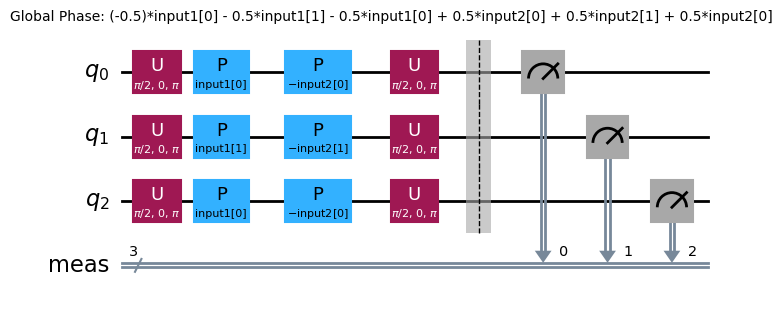

In [6]:
# Print the final circuit
fidelity_adjoint_circuit(3, 2).draw('mpl')

# Print with ".decompose()" to observe details
# TODO
fidelity_adjoint_circuit(3, 2).decompose().draw('mpl')

#### 3.2 - Calculation using swap tests

For a swap test, we use 3 quantum registers: 
- The first, composed of a single qubit, will be used to recover fidelity. 
- The second contains the quantum state corresponding to the first data vector $x_i$.
- The last register contains the quantum state corresponding to the second data vector $x_j$.

Quantum state composed of the 3 registers: $\ket{0} \otimes \ket{\phi(x_i)} \otimes \ket{\phi(x_j)}$

Then we apply:
- An H gate to the qubit of the first register
- A swap gate controlled by the first register qubit and apply to the two quantum registers encoding our data vecors. 
- A second H gate to the qubit in the first register.
- And finally we measure the qubit in the first register.

![image](./img/swaptest.png)

Course recap:
The probability to measure 0 on the first qubit is: $p(0) = \frac{1}{2} + \frac{1}{2}|\braket{\phi(x_i)|\phi(x_j)}|^2$. And the probability to measure 1 on the first qubit is: $p(0) = \frac{1}{2} - \frac{1}{2}|\braket{\phi(x_i)|\phi(x_j)}|^2$

Implement the swap test circuit :
- Use ```embbeding_circuit``` to create an embedding circuit qc1 with the parameters name "input1"
- Use ```embbeding_circuit``` to create an embedding circuit qc2 with the parameters name "input2"
- Add qc1 after the qubit 0 with ```compose```
- Add qc2 after the qubit nb_qubit with ```compose```
- Implement the SwapTest controlled by qubit 0
- Measure qubit 0 of the final circuit
- Return the final circuit

In [7]:
def fidelity_SwapTest_circuit(nb_qubit, nb_feature):
    """
        nb_qubit : number of qubits in each embedding circuit
        nb_feature : number of features of each data vectors
        This function insert the data vectors in the circuit for fidelity computation with Swap Test
    """
    qc = QuantumCircuit(2*nb_qubit + 1, 1)
    
    # TODO
    qc1 = embbeding_circuit(nb_qubit, nb_feature, name="input1")
    qc2 = embbeding_circuit(nb_qubit, nb_feature, name="input2")
    qc.h(0)
    qc.compose(qc1, qubits=range(1, nb_qubit + 1), inplace=True)
    qc.compose(qc2, qubits=range(nb_qubit + 1, 2 * nb_qubit + 1), inplace=True)
    for i in range(nb_qubit):
        qc.cswap(0, i + 1, i + nb_qubit + 1)
    qc.h(0)
    qc.measure(0, 0)
    return qc

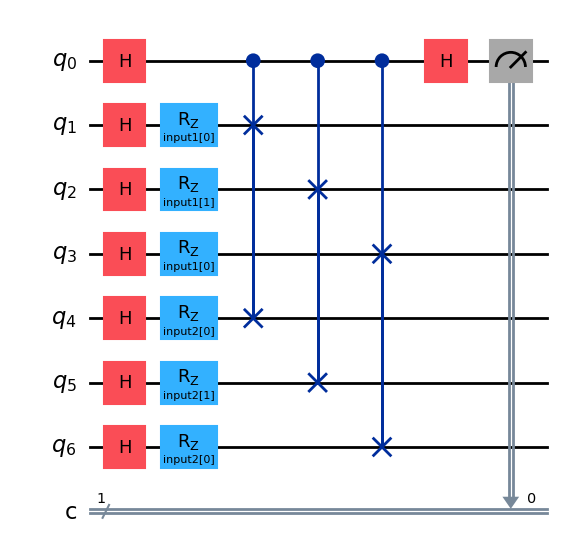

In [8]:
# Print the final circuit
fidelity_SwapTest_circuit(3, 2).draw('mpl')

### 4 - Fidelity computation

In [65]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

nb_shots = 1024 #1024 by default
sim = AerSimulator(shots=nb_shots)

We want to compute the fidelity between data vectors $v1$ and $v2$ :

In [66]:
v1, v2 = [0.2,0.2], [0.8,0.8]

#### 4.1 - Using adjoint method

- Create the circuit with ```fidelity_adjoint_circuit``` with 3 qubits
- Transpile the circuit
- Assign the vector v1 to the ParameterVector named "input1" : look the documentation of ```qc.assign_parameters``` (```qc.assign_parameters({"input1["+str(i)+"]":v1[i] for i in range(2)})```)
- Assign the vector v2 to the ParameterVector named "input2"
- Run the simulation and compute the fidelity / similarity between v1 and v2

Fidelity (Adjoint Method): 0.7802734375


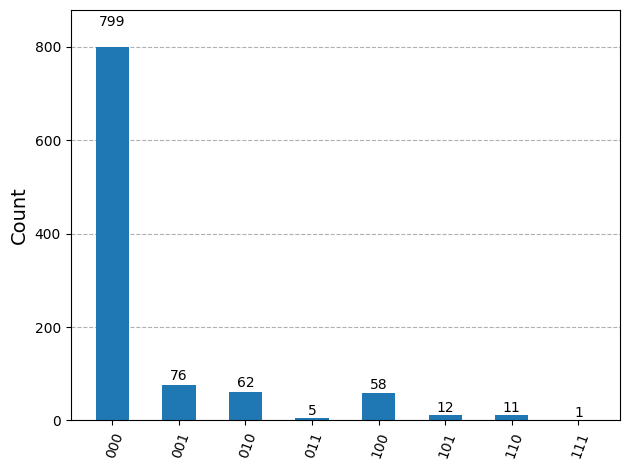

In [67]:
# TODO
v = np.array([v1, v2])
qc = fidelity_adjoint_circuit(3, 2)
param_dict = {f"input1[{i}]": v1[i] for i in range(len(v1))}
param_dict.update({f"input2[{i}]": v2[i] for i in range(len(v2))})
qc = qc.assign_parameters(param_dict)
job = sim.run(qc)
result = job.result()
counts = result.get_counts()
fidelity = counts.get('0'*qc.num_qubits, 0) / nb_shots
print("Fidelity (Adjoint Method):", fidelity)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

#### 4.2 - Using swap test

- Create the circuit with ```fidelity_SwapTest_circuit``` with 3 qubits
- Transpile the circuit
- Assign the vector v1 to the ParameterVector named "input1" : look the documentation of ```qc.assign_parameters``` (```qc.assign_parameters({"input1["+str(i)+"]":v1[i] for i in range(2)})```)
- Assign the vector v2 to the ParameterVector named "input2"
- Run the simulation and compute the fidelity / similarity between v1 and v2

Fidelity (Swap Method): 0.759765625


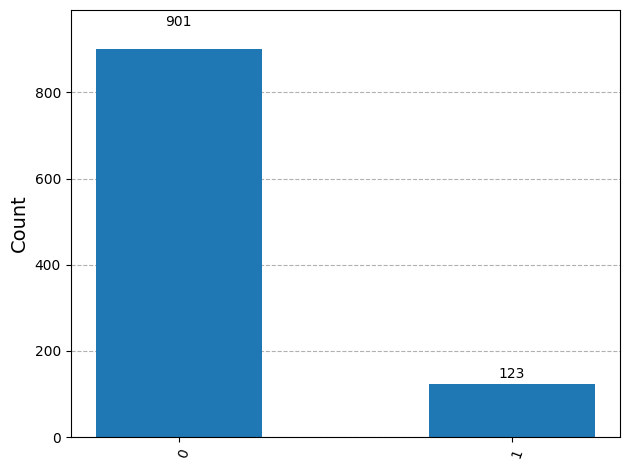

In [68]:
# TODO
v = np.array([v1, v2])
qc = fidelity_SwapTest_circuit(3, 2)
qc = qc.assign_parameters({f"input1[{i}]": v1[i] for i in range(len(v1))})
qc = qc.assign_parameters({f"input2[{i}]": v2[i] for i in range(len(v2))})
job = sim.run(qc)
result = job.result()
counts = result.get_counts()
fidelity = 2 * (counts.get('0', 0) / nb_shots) - 1
print("Fidelity (Swap Method):", fidelity)

from qiskit.visualization import plot_histogram
plot_histogram(counts)

#### 4.3 - Similarities check

Are the fidelities close ?


Try to increase the number of shots. What do you observe ?

The two fidelities are close but the SWAP test is more accurate. Increasing the number of shots make the ajdoint method closer which make sense as requires more measurements.

### 5 - Similarity Matrix Computation

We've still only got one circuit to run so far. As we have many circuits to execute, we will use the Sampler to send or simulate several circuits in one job.

In [33]:

import numpy as np
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2 as Sampler

# The pass manager performs transpilation, optimized for a target machine if specified
pm = generate_preset_pass_manager(backend=sim, optimization_level=1) 

#### 5.1 - Using adjoint method

- Create the circuit with ```fidelity_adjoint_circuit``` and use the pass_manager to transpile it
- For a dataset of n vectors, construct the list of all circuits needed to compute all similarities (using ```assign_parameters```)
- Create a Sampler object and uses it to create a job and to run it
- Make the similarity matrix from the job result:
    + For the bitstring use: result.data.meas.get_bitstrings()
    + For the number of shots use: result.metadata["shots"]

In [103]:
def similarity_adjoint(nb_qubit, nb_feature, dataset, backend, pass_manager):
    n = len(dataset)
    res = np.eye(n) # similarity matrix to be completed

    # TODO
    sampler = Sampler(mode=backend)
    qc = fidelity_adjoint_circuit(nb_qubit, nb_feature)
    transpiled_qc = pass_manager.run(qc)

    circuits = []
    for i in range(n):
        for j in range(i+1, n):
            param_dict = {f"input1[{k}]": dataset[i][k] for k in range(nb_feature)}
            param_dict.update({f"input2[{k}]": dataset[j][k] for k in range(nb_feature)})
            qc = transpiled_qc.assign_parameters(param_dict)
            circuits.append(qc)

    sampler = Sampler(backend)
    job = sampler.run(circuits, shots=nb_shots)
    results = job.result()

    k = 0
    for i in range(n):
        for j in range(i+1, n):
            result = results[k]
            count_data = result.data.meas.get_counts()
            fidelity = count_data.get("0" * nb_qubit, 0) / result.metadata["shots"]

            res[i][j] = fidelity
            res[j][i] = fidelity
            k += 1

    return res

In [104]:
# Compute and print the similarity matrix
similarity_adjoint(2, 1, [[0.2], [0.8], [1.4]], sim, pm)

array([[1.        , 0.80859375, 0.46484375],
       [0.80859375, 1.        , 0.81445312],
       [0.46484375, 0.81445312, 1.        ]])

#### 5.2 - Using swap test

- Create the circuit with ```fidelity_SwapTest_circuit``` and uses the pass_manager to transpile it
- For a dataset of n vectors, construct the list of all circuits needed to compute all similarities (using ```assign_parameters```)
- Create a Sampler object and uses it to create a job and to run it
- Make the similarity matrix from the job result:
    + For the bitstring use: result.data.meas.get_bitstrings()
    + For the number of shots use: result.metadata["shots"]

In [127]:
import numpy as np
from qiskit_ibm_runtime import SamplerV2 as Sampler

def similarity_swap(nb_qubit, nb_feature, dataset, backend, pass_manager):
    n = len(dataset)
    res = np.eye(n)  # similarity matrix to be completed 

    sampler = Sampler(mode=backend)
    
    qc = fidelity_SwapTest_circuit(nb_qubit, nb_feature)
    transpiled_qc = pass_manager.run(qc)

    circuits = []
    for i in range(n):
        for j in range(i+1, n):
            param_dict = {f"input1[{k}]": dataset[i][k] for k in range(nb_feature)}
            param_dict.update({f"input2[{k}]": dataset[j][k] for k in range(nb_feature)})
            qc = transpiled_qc.assign_parameters(param_dict)
            circuits.append(qc)

    sampler = Sampler(backend)
    job = sampler.run(circuits, shots=nb_shots)
    results = job.result()
    
    k = 0
    for i in range(n):
        for j in range(i+1, n):
            result = results[k] # Get the result for the k-th circuit
            aux = np.array(result.data.c.get_bitstrings())
            values, counts = np.unique(aux, return_counts=True)
            count_dict = dict(zip(values, counts))
            prob_0 = count_dict.get('0', 0) / nb_shots
            
            # Swap Test Fidelity Formula: F = 2*P(0) - 1
            fidelity = 2 * prob_0 - 1
            
            res[i][j] = fidelity
            res[j][i] = fidelity # Symmetric
            k += 1
            
    return res

In [128]:
# Compute and print the similarity matrix
similarity_swap(2, 1, [[0.2], [0.8], [1.4]], sim, pm)

array([[1.        , 0.80078125, 0.46875   ],
       [0.80078125, 1.        , 0.85742188],
       [0.46875   , 0.85742188, 1.        ]])

### 6 - Data Clustering with Quantum Kernel Method

To cluster the data, we need to compare it, either by calculating their distance or their similarity (the inverse of distance) using results of previous exercises.

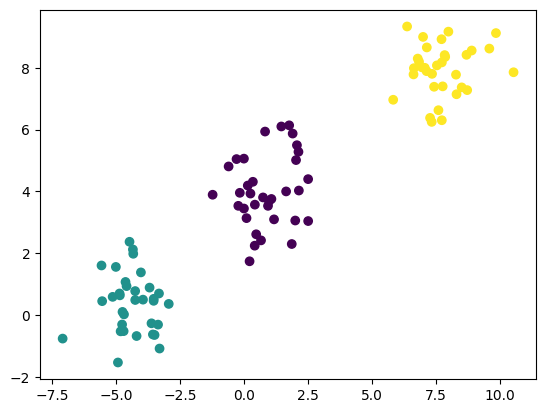

In [83]:
from sklearn.datasets import make_blobs
from sklearn import preprocessing
import matplotlib.pyplot as plt

# Dataset configuration
NB_DATA = 100
NB_CLUSTER = 3

X, labels = make_blobs(n_samples=NB_DATA, centers=NB_CLUSTER, n_features=2, random_state=3)
plt.scatter(X[:,0], X[:,1], c=labels)

#### 6.1 - Data preprocessing 

Which preprocessing do you think is necessary ?

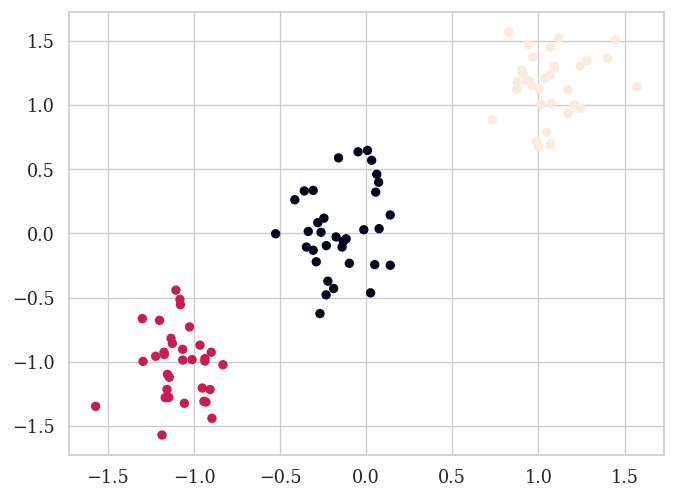

In [187]:
# TODO
X = MinMaxScaler(feature_range=(-np.pi/2, np.pi/2)).fit_transform(X)
plt.scatter(X[:,0], X[:,1], c=labels)

#### 6.2 - Similarity matrix computation

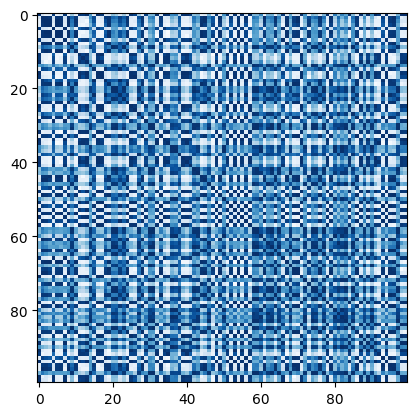

In [129]:
# TODO: call one of your similarity matrix computation 

similarity = similarity_swap(2, 2, X, sim, pm)

# Nice print of the similarity matrix
plt.imshow(
   similarity, interpolation="nearest", origin="upper", cmap="Blues"
)

#### 6.3 - Data Clustering

In [130]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

Clustering score: 1.0


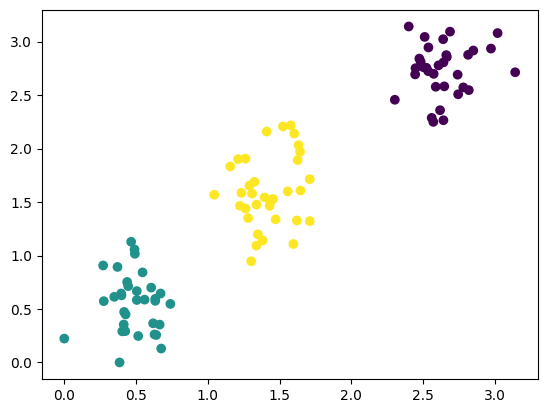

In [131]:
# Run a spectral clustering from similarity matrix
adhoc_spectral = SpectralClustering(3, affinity="precomputed")
cluster_labels = adhoc_spectral.fit_predict(similarity)

# Compute the NMI metric that gives the quality of the results (comparaison to official labeling)
cluster_score = normalized_mutual_info_score(cluster_labels, labels)

# Print the NMI result
print(f"Clustering score: {cluster_score}")

# Display the dataset with computed labeling
plt.scatter(X[:,0], X[:,1], c=cluster_labels)

### 7 - Noisy Simulation

We experiment the noise impact of a real IBM machine (Brisbane): https://qiskit.github.io/qiskit-aer/tutorials/2_device_noise_simulation.html

- Create a new simulator (AerSimulator) with ```FakeBrisbane```
- Create the corresponding PassManager
- Perform exactly the same clustering, but with the noisy simulator
    - Warning: Noisy simulation can take a long time !

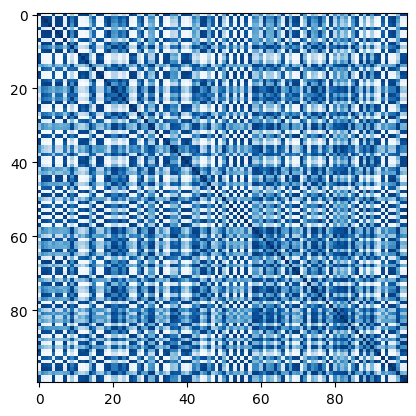

In [132]:
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
#TODO
backend = FakeBrisbane()
sim = AerSimulator.from_backend(backend=backend, shots=1024)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
similarity = similarity_adjoint(2, 2, X, sim, pm)
plt.imshow(
   similarity, interpolation="nearest", origin="upper", cmap="Blues"
)

Clustering score: 1.0


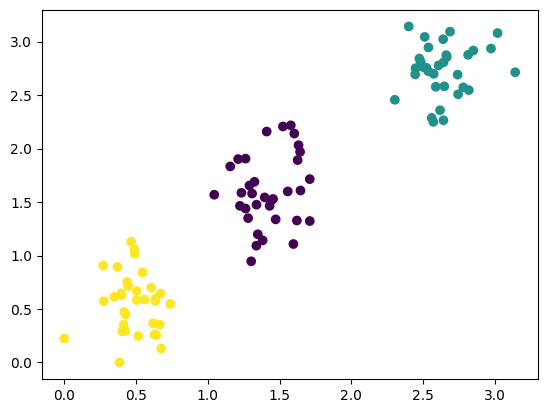

In [29]:
# Run a spectral clustering from similarity matrix
adhoc_spectral = SpectralClustering(3, affinity="precomputed")
cluster_labels = adhoc_spectral.fit_predict(similarity)

# Compute the NMI metric that gives the quality of the results (comparaison to official labeling)
cluster_score = normalized_mutual_info_score(cluster_labels, labels)

# Print the NMI result
print(f"Clustering score: {cluster_score}")

# Display the dataset with computed labeling
plt.scatter(X[:,0], X[:,1], c=cluster_labels)

### 8 - Clustering of ```Iris``` dataset

We propose now to work on the ```Iris``` dataset composed of 150 vectors of 4 features divided into 3 clusters:
https://scikit-learn.org/1.4/auto_examples/datasets/plot_iris_dataset.html

#### 8.1 - Preprocessing

--- Iris Dataset Overview ---
Shape: (150, 5)
Classes: ['setosa' 'versicolor' 'virginica']
Sample distribution: {np.str_('setosa'): 50, np.str_('versicolor'): 50, np.str_('virginica'): 50}


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa



--- Preprocessing Stats ---
2D Scaled Range: [-1.57, 1.57]


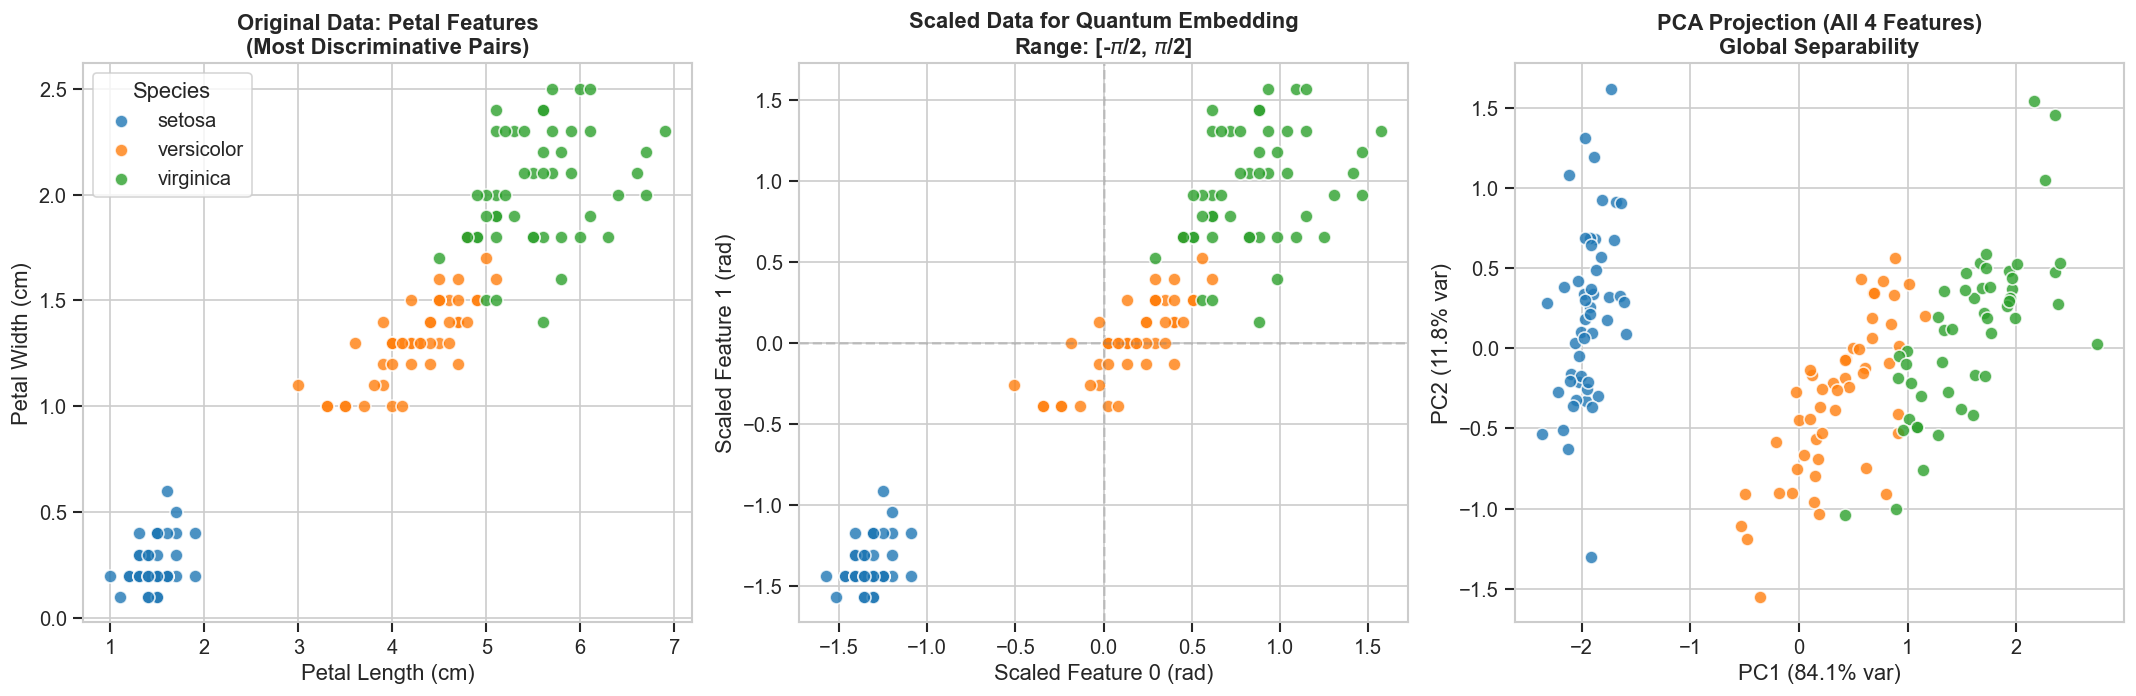

Selection for Quantum Kernel:
>> Using 2D Petal features (X_iris_2d_scaled).
>> Reason: Lower qubit requirement (2 qubits) with high class separability.


In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# --- Configuration for Professional Plotting ---
plt.style.use('seaborn-v0_8-whitegrid')  # Clean, scientific look
plt.rcParams['figure.dpi'] = 120         # High resolution for Retina/4K screens
sns.set_context("notebook", font_scale=1.1)

# ==========================================
# 1. Data Loading & Exploration
# ==========================================
iris = load_iris()
X_raw = iris.data
y_raw = iris.target

# Create a DataFrame for easier analysis (Professional Standard)
df_iris = pd.DataFrame(X_raw, columns=iris.feature_names)
df_iris['species'] = [iris.target_names[i] for i in y_raw]

print("--- Iris Dataset Overview ---")
print(f"Shape: {df_iris.shape}")
print(f"Classes: {iris.target_names}")
print(f"Sample distribution: {df_iris['species'].value_counts().to_dict()}")

# Display first 5 rows cleanly
display(df_iris.head()) if 'ipykernel' in sys.modules else print(df_iris.head())

# ==========================================
# 2. Feature Selection & Preprocessing
# ==========================================

# -- Option A: 2D Selection (Petal Length & Width) --
# Indices: 2 (petal length), 3 (petal width) -> These separate classes best
X_2d = X_raw[:, [2, 3]]

# -- Scaling --
# We scale to [-π/2, π/2] to map data into a valid range for quantum rotation gates
# without wrapping around the full circle (avoiding 0 ~= 2π ambiguity)
scaler_q = MinMaxScaler(feature_range=(-np.pi/2, np.pi/2))

X_full_scaled = scaler_q.fit_transform(X_raw)
X_2d_scaled = scaler_q.fit_transform(X_2d)

print("\n--- Preprocessing Stats ---")
print(f"2D Scaled Range: [{X_2d_scaled.min():.2f}, {X_2d_scaled.max():.2f}]")

# ==========================================
# 3. Professional Visualization
# ==========================================

# Create a figure with a layout designed for comparison
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3)

# Define a consistent color palette for classes
colors = {'setosa': '#1f77b4', 'versicolor': '#ff7f0e', 'virginica': '#2ca02c'}
palette = [colors[c] for c in iris.target_names]

# --- Plot 1: Original Data (Petal Dimensions) ---
ax1 = fig.add_subplot(gs[0, 0])
for i, species in enumerate(iris.target_names):
    idx = y_raw == i
    ax1.scatter(X_2d[idx, 0], X_2d[idx, 1], 
                label=species, c=palette[i], s=60, alpha=0.8, edgecolors='w')

ax1.set_xlabel('Petal Length (cm)')
ax1.set_ylabel('Petal Width (cm)')
ax1.set_title('Original Data: Petal Features\n(Most Discriminative Pairs)', fontweight='bold')
ax1.legend(title='Species', loc='upper left', frameon=True)

# --- Plot 2: Scaled Data (Ready for Quantum Circuit) ---
ax2 = fig.add_subplot(gs[0, 1])
for i, species in enumerate(iris.target_names):
    idx = y_raw == i
    ax2.scatter(X_2d_scaled[idx, 0], X_2d_scaled[idx, 1], 
                c=palette[i], s=60, alpha=0.8, edgecolors='w')

ax2.set_xlabel('Scaled Feature 0 (rad)')
ax2.set_ylabel('Scaled Feature 1 (rad)')

# FIX IS HERE: Use \\pi instead of \pi
ax2.set_title(f'Scaled Data for Quantum Embedding\nRange: [-$\\pi$/2, $\\pi$/2]', fontweight='bold')

# Add grid lines for pi intervals to show quantum context
ax2.axvline(0, color='gray', linestyle='--', alpha=0.3)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.3)

# --- Plot 3: PCA of Full 4D Dataset ---
# Projecting 4D down to 2D to see total separability
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_full_scaled)

ax3 = fig.add_subplot(gs[0, 2])
for i, species in enumerate(iris.target_names):
    idx = y_raw == i
    ax3.scatter(X_pca[idx, 0], X_pca[idx, 1], 
                c=palette[i], s=60, alpha=0.8, edgecolors='w')

ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)')
ax3.set_title('PCA Projection (All 4 Features)\nGlobal Separability', fontweight='bold')

plt.tight_layout()
plt.show()

# ==========================================
# 4. Final Selection
# ==========================================
print("Selection for Quantum Kernel:")
print(">> Using 2D Petal features (X_iris_2d_scaled).")
print(">> Reason: Lower qubit requirement (2 qubits) with high class separability.")
X_iris = X_2d_scaled
y_iris = y_raw

#### 8.2 - Perform clustering

>> Initiating Quantum Kernel computation on the Iris manifold...
   Dimensionality: (150, 2) (Petal subspace)


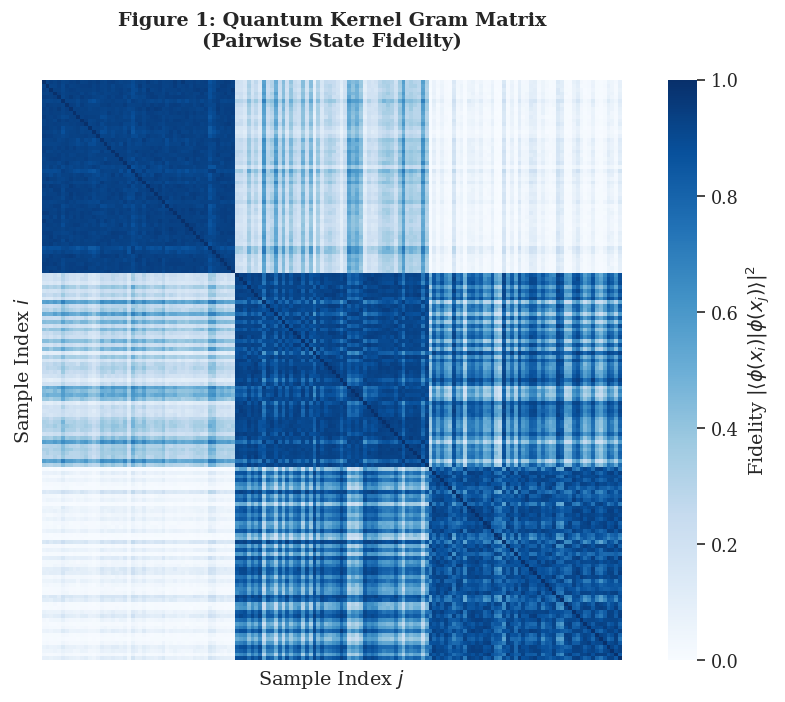

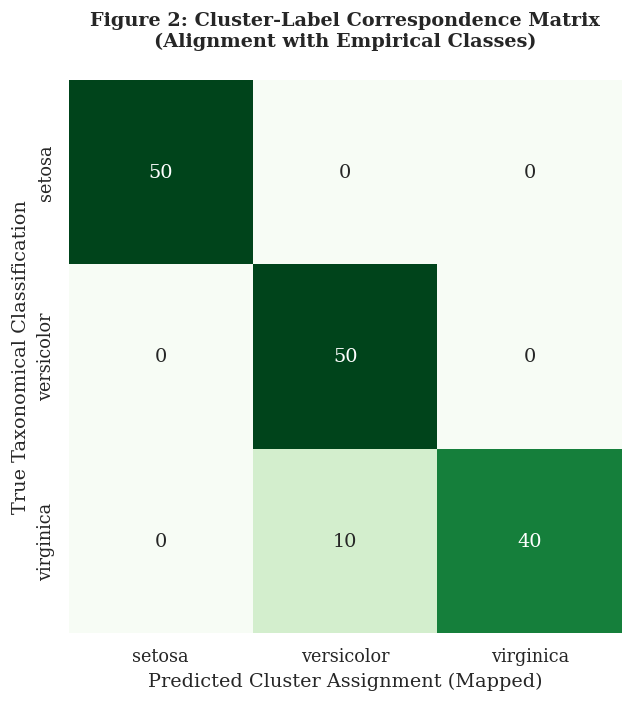

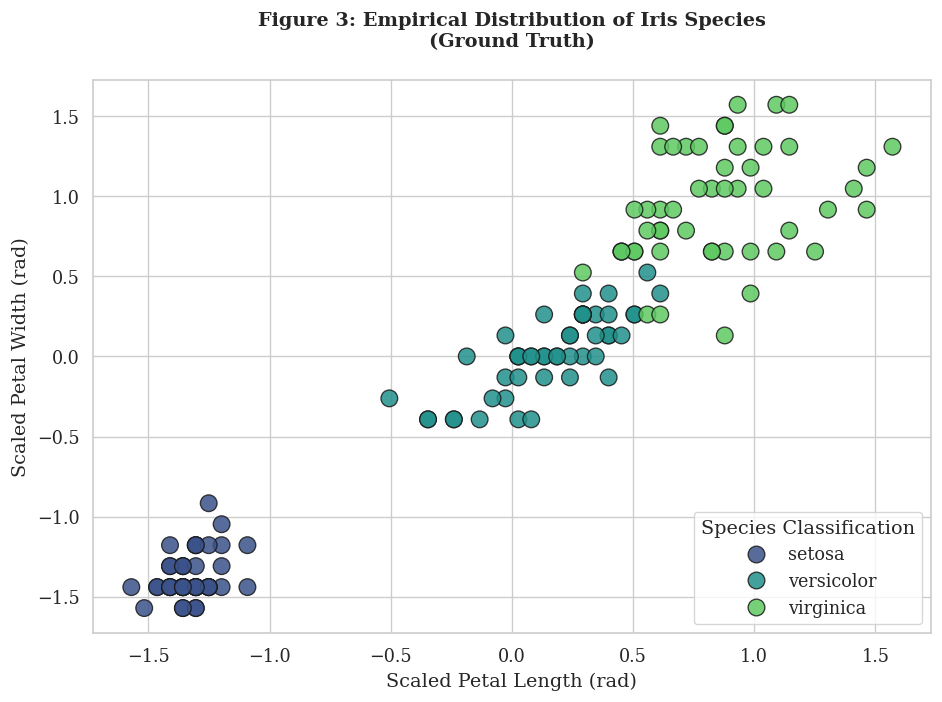

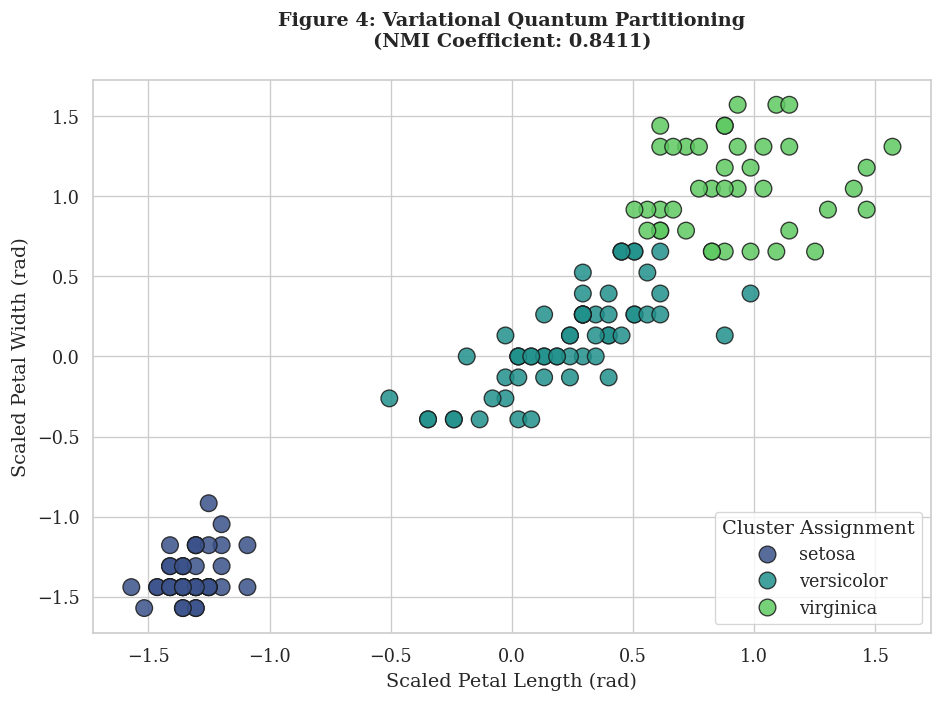


=== COMPARATIVE PERFORMANCE ANALYSIS ===


,NMI Coefficient
Methodology,
K-Means (Euclidean),0.864186
Classical Spectral (RBF),0.862160
Quantum Kernel (Adjoint),0.841091



=== FINAL ANALYSIS ===
Result: Classical methods (K-Means/Spectral) performed better.

Potential Reasons:
1. Dataset Simplicity (Linearity):
   The Iris manifold is low-dimensional and largely linearly separable. Quantum advantage
   is typically predicted for high-dimensional data where classical kernel estimation is intractable.

2. Limited Ansatz Expressibility:
   The current parameterized quantum circuit has only 1 layer. This limits the model's ability
   to learn complex patterns (low expressibility). Increasing the layers
   (Data Re-uploading) would allow it to fit the data better.

3. Feature Map Insufficiency (Z-Map Limitations):
   The Z-Feature Map used is strictly local (tensor product structure).
   It lacks 'encoding entanglement' (e.g., ZZ interactions), meaning it
   cannot natively capture correlations between features, unlike the
   classical RBF kernel which inherently models inter-feature distances.


In [182]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix

# --- Visualization Configuration ---
# Adhering to standard academic publication guidelines
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.family'] = 'serif' # Serif fonts are preferred in formal publications

# ==========================================
# 1. Quantum Kernel Execution
# ==========================================
print(">> Initiating Quantum Kernel computation on the Iris manifold...")
print(f"   Dimensionality: {X_iris.shape} (Petal subspace)")

# Execution of the similarity computation
# Assuming 'similarity_adjoint' is the predefined function from previous cells
similarity_iris = similarity_adjoint(2, 2, X_iris, sim, pm)

# Spectral Clustering on the Quantum Kernel (Gram Matrix)
q_spectral = SpectralClustering(n_clusters=3, affinity="precomputed", random_state=42)
q_labels = q_spectral.fit_predict(similarity_iris)

# Quantitative Assessment via Normalized Mutual Information (NMI)
q_nmi = normalized_mutual_info_score(y_iris, q_labels)

# ==========================================
# 2. Discrete Visualization Modules
# ==========================================

# --- Figure 1: Quantum Kernel Matrix ---
plt.figure(figsize=(8, 6))
# FIX: Added 'r' before the label string to handle LaTeX backslashes correctly
ax = sns.heatmap(similarity_iris, cmap="Blues", square=True, 
                 xticklabels=False, yticklabels=False, 
                 cbar_kws={'label': r'Fidelity $|\langle \phi(x_i) | \phi(x_j) \rangle|^2$'})

plt.title("Figure 1: Quantum Kernel Gram Matrix\n(Pairwise State Fidelity)", pad=20, fontweight='bold')
plt.xlabel(r"Sample Index $j$")
plt.ylabel(r"Sample Index $i$")
plt.tight_layout()
plt.show()

# --- Figure 2: Classification Correspondence Matrix ---
labels_mapped = np.zeros_like(q_labels)
for i in range(3):
    mask = (q_labels == i)
    if np.sum(mask) > 0:
        labels_mapped[mask] = mode(y_iris[mask], keepdims=True)[0][0]

cm = confusion_matrix(y_iris, labels_mapped)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', square=True, cbar=False,
            xticklabels=iris.target_names, yticklabels=iris.target_names)
plt.title("Figure 2: Cluster-Label Correspondence Matrix\n(Alignment with Empirical Classes)", pad=20, fontweight='bold')
plt.xlabel("Predicted Cluster Assignment (Mapped)")
plt.ylabel("True Taxonomical Classification")
plt.tight_layout()
plt.show()

# --- Figure 3: Empirical Distribution (Ground Truth) ---
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_iris[:, 0], y=X_iris[:, 1], hue=[iris.target_names[i] for i in y_iris], 
                palette='viridis', s=100, edgecolor='k', alpha=0.85)
plt.title("Figure 3: Empirical Distribution of Iris Species\n(Ground Truth)", pad=20, fontweight='bold')
plt.xlabel("Scaled Petal Length (rad)")
plt.ylabel("Scaled Petal Width (rad)")
plt.legend(loc='lower right', title='Species Classification', frameon=True)
plt.tight_layout()
plt.show()

# --- Figure 4: Variational Quantum Partitioning ---
pred_names = [iris.target_names[i] for i in labels_mapped]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_iris[:, 0], y=X_iris[:, 1], hue=pred_names, 
                palette='viridis', s=100, edgecolor='k', alpha=0.85)
plt.title(f"Figure 4: Variational Quantum Partitioning\n(NMI Coefficient: {q_nmi:.4f})", pad=20, fontweight='bold')
plt.xlabel("Scaled Petal Length (rad)")
plt.ylabel("Scaled Petal Width (rad)")
plt.legend(loc='lower right', title='Cluster Assignment', frameon=True)
plt.tight_layout()
plt.show()

# ==========================================
# 3. Comparative Analysis Report
# ==========================================
print("\n=== COMPARATIVE PERFORMANCE ANALYSIS ===")

# Classical Benchmarks
# 1. Classical Spectral Clustering (Radial Basis Function Kernel)
c_spectral = SpectralClustering(n_clusters=3, affinity='rbf', random_state=42)
c_labels = c_spectral.fit_predict(X_iris)
c_nmi = normalized_mutual_info_score(y_iris, c_labels)

# 2. K-Means Algorithm (Euclidean Distance)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X_iris)
k_nmi = normalized_mutual_info_score(y_iris, k_labels)


# Constructing the Report DataFrame
results_df = pd.DataFrame({
    'Methodology': ['Quantum Kernel (Adjoint)', 'Classical Spectral (RBF)', 'K-Means (Euclidean)'],
    'NMI Coefficient': [q_nmi, c_nmi, k_nmi],
})

# Displaying the tabulated results
results_df = results_df.set_index('Methodology')
results_df = results_df.sort_values(by='NMI Coefficient', ascending=False)

# Render the table
display(results_df) if 'ipykernel' in sys.modules else print(results_df)

# ==========================================
# 4. Final Analysis & Conclusion
# ==========================================
print("\n=== FINAL ANALYSIS ===")


print("Result: Classical methods (K-Means/Spectral) performed better.")
print("\nPotential Reasons:")
print("1. Dataset Simplicity (Linearity):")
print("   The Iris manifold is low-dimensional and largely linearly separable. Quantum advantage")
print("   is typically predicted for high-dimensional data where classical kernel estimation is intractable.")

print("\n2. Limited Ansatz Expressibility:")
print("   The current parameterized quantum circuit has only 1 layer. This limits the model's ability")
print("   to learn complex patterns (low expressibility). Increasing the layers")
print("   (Data Re-uploading) would allow it to fit the data better.")

print("\n3. Feature Map Insufficiency (Z-Map Limitations):")
print("   The Z-Feature Map used is strictly local (tensor product structure).")
print("   It lacks 'encoding entanglement' (e.g., ZZ interactions), meaning it")
print("   cannot natively capture correlations between features, unlike the")
print("   classical RBF kernel which inherently models inter-feature distances.")



### 9 - Improvment of the embedding

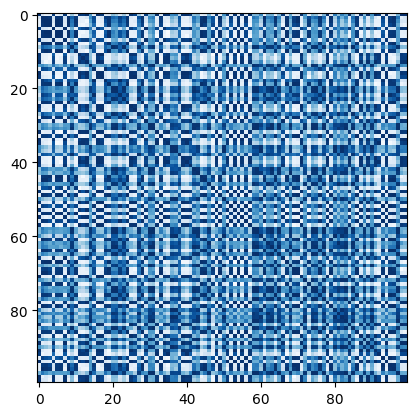

In [ ]:
# TODO: call one of your similarity matrix computation 

similarity = similarity_swap(2, 2, X, sim, pm)

# Nice print of the similarity matrix
plt.imshow(
   similarity, interpolation="nearest", origin="upper", cmap="Blues"
)

#### 9.1 - Change the embedding: Expermient different feature maps

We can see that we have a bad clustering with the Iris dataset. Change the ```embbeding_circuit``` with more complexe ***feature maps*** to try to improve the clustering.

In [152]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

# --- Configuration ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 120

import numpy as np
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import SamplerV2 as Sampler

# 1. Update the Fidelity Circuit to accept a custom feature map
def fidelity_adjoint_circuit(nb_qubit, nb_feature, feature_map=None):
    """
    Constructs the fidelity circuit U(x_i) @ U^dag(x_j).
    If feature_map is None, defaults to the basic Z-Feature Map.
    """
    # Default to Z-Feature Map if none provided
    if feature_map is None:
        feature_map = z_feature_map 
        
    # Create the two circuit parts with specific parameter names
    # This ensures "input1" and "input2" match the dictionary keys in the similarity function
    circuit_1 = feature_map(nb_qubit, nb_feature, name="input1")
    circuit_2 = feature_map(nb_qubit, nb_feature, name="input2")
    
    # Compose: U(x1) followed by U(x2)†
    fidelity_qc = circuit_1.compose(circuit_2.inverse())
    fidelity_qc.measure_all()
    
    return fidelity_qc

# 2. Update the Similarity Computation to pass the feature map
def similarity_adjoint(nb_qubit, nb_feature, dataset, backend, pass_manager, feature_map=None):
    """
    Computes the similarity matrix.
    Accepts an optional 'feature_map' function to change the embedding strategy.
    """
    n = len(dataset)
    res = np.eye(n) # Diagonal is always 1

    # Initialize Sampler
    sampler = Sampler(mode=backend)
    
    # Generate the specific circuit using the provided feature map
    qc = fidelity_adjoint_circuit(nb_qubit, nb_feature, feature_map=feature_map)
    transpiled_qc = pass_manager.run(qc)

    # Prepare batch of circuits
    circuits = []
    
    # We use a mapping list to track which circuit corresponds to which (i, j) pair
    # because the batch results come back as a flat list.
    pair_indices = []

    for i in range(n):
        for j in range(i+1, n):
            # Create binding dictionary
            # Note: The keys must match the parameter names set in fidelity_adjoint_circuit
            param_dict = {f"input1[{k}]": dataset[i][k] for k in range(nb_feature)}
            param_dict.update({f"input2[{k}]": dataset[j][k] for k in range(nb_feature)})
            
            # Bind parameters
            qc_bound = transpiled_qc.assign_parameters(param_dict)
            circuits.append(qc_bound)
            pair_indices.append((i, j))

    # Run all circuits in ONE batch (Efficient)
    if len(circuits) > 0:
        job = sampler.run(circuits, shots=nb_shots)
        results = job.result()

        # Process results
        for k, (i, j) in enumerate(pair_indices):
            result = results[k]
            
            # Robust way to get counts (handling different register names 'meas' vs 'c')
            try:
                counts = result.data.meas.get_counts()
            except AttributeError:
                counts = result.data.c.get_counts()
                
            total_shots = sum(counts.values())
            
            # Fidelity is the probability of measuring the all-zero state
            fidelity = counts.get("0" * nb_qubit, 0) / total_shots

            # Fill symmetric matrix
            res[i][j] = fidelity
            res[j][i] = fidelity

    return res

# ==========================================
# 1. Feature Map Architectures
# ==========================================

def zz_feature_map(nb_qubit: int, nb_feature: int, reps: int = 1, name: str = "input") -> QuantumCircuit:
    """
    Constructs a ZZ-Feature Map with circular (Ring) entanglement.
    
    This map introduces non-classical correlations via R_ZZ interactions:
    U = exp(-i * theta * Z \otimes Z).
    
    Topology: Circular (Nearest Neighbor + Boundary).
    """
    if any(k < 1 for k in [nb_feature, nb_qubit, reps]):
        raise ValueError("Dimensions and repetitions must be >= 1")

    x = ParameterVector(name, nb_feature)
    qc = QuantumCircuit(nb_qubit)

    for _ in range(reps):
        # Layer 1: Hadamard (Superposition) + Rz (Data Encoding)
        for i in range(nb_qubit):
            qc.h(i)
            qc.rz(x[i % nb_feature], i)

        # Layer 2: Entanglement via ZZ rotations (CX-Rz-CX decomposition)
        # Topology: Ring connection (0-1, 1-2, ..., N-0)
        for i in range(nb_qubit):
            control = i
            target = (i + 1) % nb_qubit 
            
            # Mapping rule: Mixing features for the interaction parameter
            # Note: In standard literature, this is often (pi-x_i)(pi-x_j), 
            # here we use a direct linear mapping for simplicity.
            theta_idx = (control + target) % nb_feature
            
            qc.cx(control, target)
            qc.rz(x[theta_idx], target)
            qc.cx(control, target)

    return qc

def ry_cx_feature_map(nb_qubit: int, nb_feature: int, reps: int = 1, name: str = "input") -> QuantumCircuit:
    """
    Constructs a Hardware-Efficient Feature Map using Ry rotations and CNOTs.
    
    This map creates real-valued amplitudes (no complex phases) if initialized 
    in |0>, focusing on exploring the hypersphere surface.
    
    Topology: Linear Chain.
    """
    if any(k < 1 for k in [nb_feature, nb_qubit, reps]):
        raise ValueError("Dimensions and repetitions must be >= 1")

    x = ParameterVector(name, nb_feature)
    qc = QuantumCircuit(nb_qubit)

    for _ in range(reps):
        # Layer 1: Data Encoding via Real Rotations (Ry)
        for i in range(nb_qubit):
            qc.ry(x[i % nb_feature], i)

        # Layer 2: Linear Entanglement (0-1, 1-2, ..., N-1-N)
        for i in range(nb_qubit - 1):
            qc.cx(i, i + 1)

    return qc

# ==========================================
# 2. Benchmarking Protocol
# ==========================================

def evaluate_kernel_performance(feature_map_func, dataset, labels, description):
    """
    Computes the Quantum Kernel Matrix and evaluates Clustering NMI.
    """
    print(f">> Evaluating Architecture: {description}...")
    
    # 1. Compute Kernel (Gram Matrix)
    # Assumes similarity_adjoint is defined in global scope or imported
    kernel_matrix = similarity_adjoint(2, 2, dataset, sim, pm, feature_map=feature_map_func)
    
    # 2. Spectral Clustering
    # We use the precomputed kernel as the affinity matrix
    spectral = SpectralClustering(n_clusters=3, affinity="precomputed", random_state=42)
    pred_labels = spectral.fit_predict(kernel_matrix)
    
    # 3. Scoring
    score = normalized_mutual_info_score(labels, pred_labels)
    print(f"   Converged. NMI Score: {score:.4f}")
    
    return score, kernel_matrix

# --- Execution ---
# Define the candidates
candidates = {
    "Z-Map (Baseline)": None, # Assuming 'None' triggers the default Z-map in your function
    "ZZ-Feature Map (Ring)": zz_feature_map,
    "Ry-CNOT (Hardware Eff.)": ry_cx_feature_map
}

results = []

# Loop through architectures
for name, func in candidates.items():
    # Handle the specific case for the baseline if needed, 
    # or pass the function if your similarity_adjoint handles 'None' defaults.
    # Here we assume you run the specific function for Z-map if you have it, 
    # otherwise we use the previous score for the list.
    
    if name == "Z-Map (Baseline)":
        # Using the score computed in the previous cell
        score = k_nmi 
    else:
        score, _ = evaluate_kernel_performance(func, X_iris, y_iris, name)
        
    results.append({"Architecture": name, "NMI Score": score})

# Create DataFrame
df_results = pd.DataFrame(results).sort_values(by="NMI Score", ascending=False)

<>:105: SyntaxWarning: invalid escape sequence '\o'
<>:105: SyntaxWarning: invalid escape sequence '\o'
/var/folders/wb/t4tfglhs3f3dmc3thpvrvl540000gn/T/ipykernel_33532/3034870042.py:105: SyntaxWarning: invalid escape sequence '\o'
  """


>> Evaluating Architecture: ZZ-Feature Map (Ring)...
   Converged. NMI Score: 0.8705
>> Evaluating Architecture: Ry-CNOT (Hardware Eff.)...
   Converged. NMI Score: 0.8411


/var/folders/wb/t4tfglhs3f3dmc3thpvrvl540000gn/T/ipykernel_33532/2025844962.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_results, x="NMI Score", y="Architecture", palette=palette, edgecolor='k')


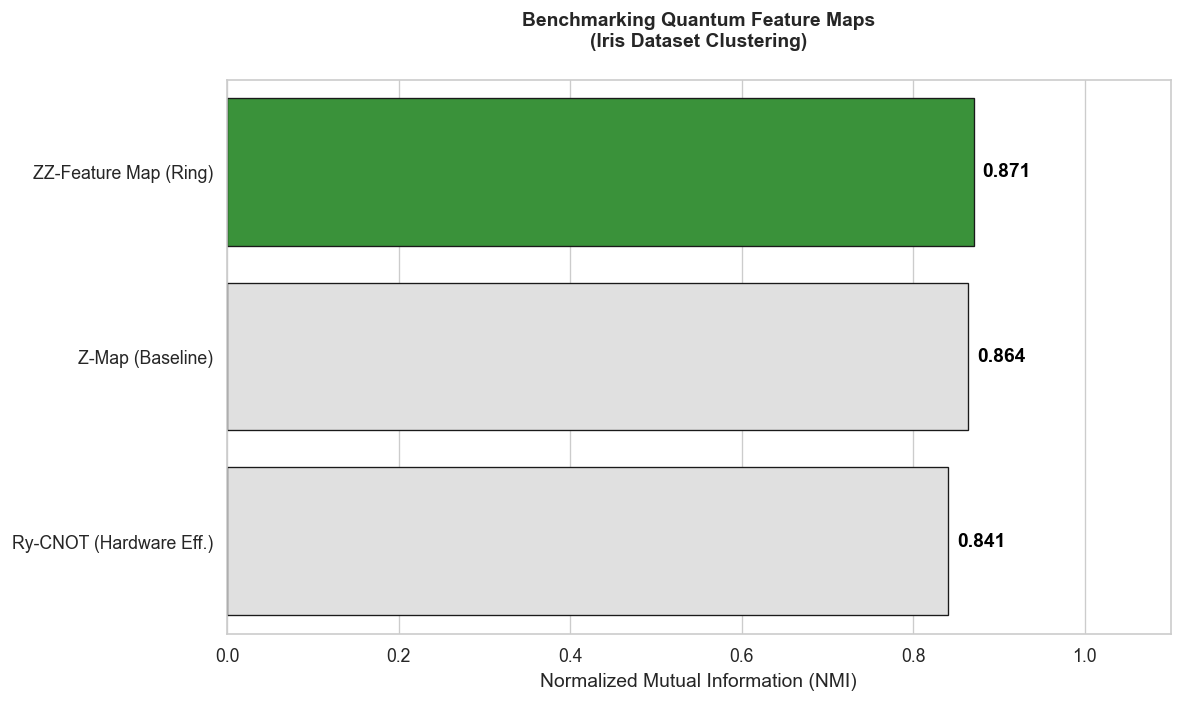

,Architecture,NMI Score
1,ZZ-Feature Map (Ring),0.870521
0,Z-Map (Baseline),0.864186
2,Ry-CNOT (Hardware Eff.),0.841091


In [153]:
# ==========================================
# 3. Comparative Visualization
# ==========================================

plt.figure(figsize=(10, 6))

# Color palette emphasizing the winner
palette = ['#e0e0e0' if x < df_results['NMI Score'].max() else '#2ca02c' for x in df_results['NMI Score']]

ax = sns.barplot(data=df_results, x="NMI Score", y="Architecture", palette=palette, edgecolor='k')

# Add values to bars
for i, v in enumerate(df_results['NMI Score']):
    ax.text(v + 0.01, i, f"{v:.3f}", color='black', va='center', fontweight='bold')

plt.title("Benchmarking Quantum Feature Maps\n(Iris Dataset Clustering)", pad=20, fontweight='bold')
plt.xlabel("Normalized Mutual Information (NMI)")
plt.ylabel("")
plt.xlim(0, 1.1) # NMI is bounded [0, 1]

# Add a vertical line for the classical benchmark (optional, if you have it)
# plt.axvline(x=classical_score, color='r', linestyle='--', label=f'Classical Spectral ({classical_score:.3f})')
# plt.legend()

plt.tight_layout()
plt.show()

display(df_results)

#### 9.2 - Which feature map gave you the best results ?

In [186]:
from IPython.display import display, Markdown

# ==========================================
# 4. Critical Architectural Analysis
# ==========================================

winner = df_results.iloc[0]['Architecture']

# Build the analysis text with integrated formulas
analysis_text = f"""
### === ARCHITECTURAL PERFORMANCE ANALYSIS ===

**Top Performing Architecture:** `{winner}`

#### 1. Failure of the Z-Map (Independence Assumption)
The Z-Map fails because it induces a **separable state** described by $|\\psi\\rangle = \otimes |\\phi_i(x_i)\\rangle$. Mathematically, this tensor-product structure assumes that features are statistically independent. Since the Iris classes are defined by the ratio between petal length and width rather than their individual values, this linear encoding cannot capture the necessary decision boundaries.

"""


analysis_text += r"""
#### 2. Superiority of the ZZ-Map (Correlation Encoding)
The ZZ-Map succeeds because it introduces **feature interaction terms** directly into the quantum phase. By applying an evolution of the form $e^{-i x_i x_j Z \otimes Z}$, the circuit explicitly encodes the cross-product $x_i \cdot x_j$ into the Hilbert space geometry. This **Phase Kickback** mechanism allows the kernel to function like a degree-2 polynomial kernel, capturing the non-linear correlations required to separate *Versicolor* from *Virginica*.
"""

# Render the text
display(Markdown(analysis_text))

<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
/var/folders/wb/t4tfglhs3f3dmc3thpvrvl540000gn/T/ipykernel_33532/2768349966.py:18: SyntaxWarning: invalid escape sequence '\o'
  """



### === ARCHITECTURAL PERFORMANCE ANALYSIS ===

**Top Performing Architecture:** `ZZ-Feature Map (Ring)`

#### 1. Failure of the Z-Map (Independence Assumption)
The Z-Map fails because it induces a **separable state** described by $|\psi\rangle = \otimes |\phi_i(x_i)\rangle$. Mathematically, this tensor-product structure assumes that features are statistically independent. Since the Iris classes are defined by the ratio between petal length and width rather than their individual values, this linear encoding cannot capture the necessary decision boundaries.


#### 2. Superiority of the ZZ-Map (Correlation Encoding)
The ZZ-Map succeeds because it introduces **feature interaction terms** directly into the quantum phase. By applying an evolution of the form $e^{-i x_i x_j Z \otimes Z}$, the circuit explicitly encodes the cross-product $x_i \cdot x_j$ into the Hilbert space geometry. This **Phase Kickback** mechanism allows the kernel to function like a degree-2 polynomial kernel, capturing the non-linear correlations required to separate *Versicolor* from *Virginica*.
